<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/StudentNotebookSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Flow Matching Library
!pip install torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 849.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torchvision import datasets, transforms

# Get MNIST data and format into torch
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=mnist_transform,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.92MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


In [ ]:
# Create a dataloader with batch size 128

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, drop_last=True
)


In [ ]:
from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel
from torchdyn.core import NeuralODE


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Construct a class conditional torchcfm.models.unet UNetModel with 32 channels, 1 residual block and send to GPU

# Then initialize the Conditional Flow Matcher with sigma=0.

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

In [ ]:
# Training Loop, train for 5 epochs
for epoch in range(5):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        # Get final image and label
        x1 = data[0].to(device)
        y = data[1].to(device)

        # Generate random noise
        x0 = torch.randn_like(x1)

        # Sample along the optimal transport (straight line) at some t
        # (xt) and find the vector to x1 (ut)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

        # Run our model and predict a velocity at the sampled point
        vt = model(t, xt, y)

        # MSE Loss
        loss = torch.mean((vt - ut) ** 2)

        # Backprop and Optimize
        loss.backward()
        optimizer.step()
        print(f"\r epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="")

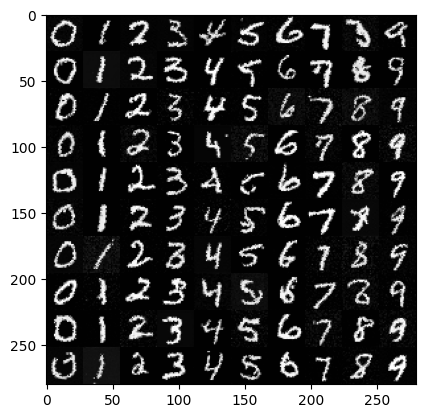

In [ ]:
# Inference! Use torchdiffeq.odeint to solve the differential equation
# with the "dopri5" solver,atol=1e-4, rtol=1e-4
# Remember the function is our model, conditioned with the class
# the initial value is random noise, and the evaluation points are just
# equal-spaced points from 0-1

import torchdiffeq
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt


# Generate 10 of each class label
generated_class_list = torch.arange(10, device=device).repeat(10)

with torch.no_grad():

      traj = torchdiffeq.odeint(
          lambda t, x: model.forward(t, x, generated_class_list),
          torch.randn(100, 1, 28, 28, device=device),
          torch.linspace(0, 1, 2, device=device),
          atol=1e-4,
          rtol=1e-4,
          method="dopri5",
      )



# traj shape: [time steps, # of images, 1 channel, 28, 28]

# Get the last timestep and reshape into an image form

grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()